## Simulation-Based Inference: Type1a Supernovae, Coverage Check
>Created: March 26, 2023, for CLASHEP 2023, San Esteban, Chile, Harrison B. Prosper<br>
>Updated: April 7, 2023 HBP




### Introduction 

This notebook checks the coverage of the confidence sets created in the notebook __02_phantom_inference.ipynb__ for a 2-parameter cosmological model fitted to the data from Type1a supernovae. (See phantom_model.ipynb for details.) The __frequentist principle__ requires that the coverage probability be bounded from below by the desired __confidence level__ (CL). In practice, if the coverage probability is within about 5 to 10\% of the desired CL that should be considered satisfactory.

### Coverage
The hypothesis $H_0 : \theta = \theta_0$ is rejected whenever the p-value $\mathbb{P}(\lambda \gt \lambda_0| \theta_0) \lt 1 - \tau = \alpha$, where $\tau$ is the confidence level. The corollary is that the hypothesis is *not* rejected if $\mathbb{P}(\lambda \le \lambda_0| \theta_0) \le \tau$, which therefore determines whether or not the point $\theta_0$ lies within the $\tau$-confidence set. This observation is the key to the algorithm below for checking the coverage probability.

  1. For each of 500 randomly sampled parameter points $\theta_0$ (chosen from the 95\% confidence set computed using real Type 1a data) simulate 4000 Type 1a data sets, each consisting of simulated data for 580 Type 1a supernovae and compute the test statistic $\lambda_0$ for each data set.
      1. For each value $\tau \in [0.683, 0.8, 0.9, 0.95]$, compute the coverage probability, that is, the relative frequency $p$ with which statements of the form $\mathbb{P}(\lambda \le \lambda_0| \theta_0) \leq \tau$ are true over the ensemble of 4000 test statistics.
  1. If the simulation-based inference is valid, we expect $p \approx \tau$.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# module to save results
import joblib as jb

# pytorch
import torch
import torch.nn as nn

# to reload modules
import importlib

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

In [3]:
%run phantom_model.ipynb

In [4]:
# read simulated Type1a data that mimick the real data for 580 supernova

datafile = 'data/type1a_simdata.csv.gz'
print('loading %s' % datafile)
tdata = pd.read_csv(datafile)

# get (unscaled) boundaries of parameter subspace 
xmin  = int(10*(tdata.n.min()+0.01))/10
xmax  = int(10*(tdata.n.max()+0.01))/10

ymin  = int(10*(tdata.H0.min()+0.01))/10
ymax  = int(10*(tdata.H0.max()+0.01))/10

# put everything into a bag called for convenience
class Bag:
    pass

bag = Bag()
bag.name   = 'phantom'

bag.weight = 'Z0'  # see hist_data
bag.xscale = 10    # scale by which to reduce "n" parameter
bag.xbins  = 10
bag.xmin   = xmin / bag.xscale
bag.xmax   = xmax / bag.xscale
bag.xstep  = 1    / bag.xscale
bag.xname  = 'n'
bag.xlabel = 'n'

bag.yscale = 100   # scale by which to reduce "H0" parameter
bag.ybins  = 10
bag.ymin   = ymin / bag.yscale
bag.ymax   = ymax / bag.yscale
bag.ystep  = 2    / bag.yscale
bag.yname  = 'H0'
bag.ylabel = 'H_0'

filename   = 'data/type1a_union2.1.txt'
bag.z, bag.x, bag.dx = read_data(filename)

# reduce the dynamic range of parameters n and H0
tdata.n   /= bag.xscale
tdata.H0  /= bag.yscale

features   = ['lo', 'n', 'H0']  # inputs into ML model
target     = 'Zo'               # targets for ML model

print()
print('number of rows:', len(tdata))
print(f'xmin: {bag.xmin:4.2f}, xmax: {bag.xmax:4.2f}')
print(f'ymin: {bag.ymin:4.2f}, ymax: {bag.ymax:4.2f}')

tdata[:5]

loading data/type1a_simdata.csv.gz
number of observations: 580
     	         z	         x +/- dx        
    0	     0.028	   35.3466 +/- 0.2239    
  100	     0.065	   37.3067 +/- 0.1628    
  200	     0.194	   39.9615 +/- 0.1264    
  300	     0.620	   43.2280 +/- 0.3903    
  400	     0.710	   43.0220 +/- 0.1843    
  500	     0.564	   42.3729 +/- 0.2920    

number of rows: 275000
xmin: 0.05, xmax: 0.60
ymin: 0.66, ymax: 0.76


,n,H0,l,l0,lo,Z0,Zo
0,0.393632,0.730757,1.006532,1.015473,0.970374,1,0
1,0.292003,0.696037,0.991506,1.006351,1.541803,1,1
2,0.365906,0.708710,1.034574,1.024765,1.057431,0,1
3,0.553187,0.739221,0.988936,1.093398,1.444401,1,1
4,0.421428,0.681756,1.041732,1.340285,1.770373,1,1


### Load 95\% Confidence Set

A confidence set at confidence level (CL) $100 \times \tau$\% is the set of 
 all parameter points $\theta_0 \equiv (n, H_0)$ for which
$$\mathbb{P}(\lambda \le \lambda_0 | n, H_0) \le \tau,$$

where $\lambda_0$ is the observed value of the test statistic for a given point $(n, H_0)$. Since $\lambda_0$ depends both on the data ($D$), which are *fixed*, as well as on the parameter point $\theta_0$, in general, $\lambda_0(D, \theta)$ will vary from one parameter point to the next.

The 95\% CL confidence set pertains to the Union 2.1 supernovae data.

In [5]:
# read 95% confidence set
bag.CL = 0.95
c95    = pd.read_csv('data/type1a_95CL.csv')
n      = c95.n.to_numpy()
H0     = c95.H0.to_numpy()
c95[:10]

,n,H0
0,0.366026,0.728173
1,0.487778,0.738300
2,0.382864,0.728365
3,0.296969,0.699969
4,0.368471,0.723029
5,0.414139,0.742505
6,0.464234,0.730123
7,0.416906,0.733030
8,0.329003,0.697028
9,0.392057,0.722914


### Load trained ML model

Load the model that approximates $\mathbb{P}(\lambda < \lambda_0| n, H_0)$.

In [6]:
import phantom_dnn as NN
importlib.reload(NN)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

name     = NN.name
model    = NN.model
modelfile= f'{name:s}.dict'
print('load model: %s' % modelfile)
modeldict = torch.load(modelfile)
NN.model.load_state_dict(modeldict)

print(model)
print('number of parameters: %d' % number_of_parameters(model))

load model: phantom.dict
Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): ReLU()
  (10): Linear(in_features=20, out_features=1, bias=True)
  (11): Sigmoid()
)
number of parameters: 1781


### Place a simple wrapper around the ML model for convenience

In [7]:
def cdf(l, n, H, f=model):   
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    X = torch.Tensor(np.array([l, n, H]).T)
    Y = model(X).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

### Check Coverage Probability 

For a given *fixed* point $(n, H_0)$, simulate 4,000 instances of 580 Type 1a data. For each data instance, $D$, compute the test statistic $\lambda_0 \equiv \lambda(D, n, H_0)$. By definition, if $\mathbb{P}(\lambda \le \lambda_0 | n, H_0) \le \tau$, where $\tau$ is the desired confidence level the point $(n, H_0)$ lies within the confidence set associated with $D$. The coverage probability, $p$, is the fraction of data instances for which this statement is true. If our neural network approximation of the cdf $\mathbb{P}(\lambda \le \lambda_0 | n, H_0)$ is accurate, then we expect $p \approx \tau$.

#### Simulate test statistics for given parameter points

In [8]:
def simulate_test_statistics(n, H0, d, size=4000):
    
    # numpy array for test statistics
    l = np.zeros(size)
    
    for i in range(size):
        
        # compute distance moduli for given parameter point (n, H0)
        mu= distance_modulus(d.z, n, H0)
        
        # generate data
        x = np.random.normal(loc=mu, scale=d.dx)
        
        # compute test statistic
        y = (x - mu)/d.dx 
        l[i] = (y**2).mean()
        
    l = np.sqrt(l)
    if size < 2:
        return l[0]
    else:
        return l

In [9]:
from tqdm import tqdm
N = 500
statistics = []
for i in tqdm(range(N)):
    statistics.append( simulate_test_statistics(n[i], H0[i], bag) )

100%|█████████████████████████████████████████| 500/500 [01:55<00:00,  4.32it/s]


#### Compute coverage probability $\mathbb{P}(\theta_0 \in R(D) | \theta_0)$

In [10]:
def compute_coverage(cdf, l, n, H0, tau=0.683):
    # N: number of parameter points
    # K: number of data instances / parameter point
    N, K = l.shape
    cov  = [0] * N
    ecov = [0] * N
    for j, x, y in zip(range(N), n, H0):
        x = np.full((K), x)
        y = np.full((K), y)
        p = cdf(l[j], x, y)
        # compute coverage
        cov[j]  = np.mean(p <= tau)
        ecov[j] = np.sqrt(cov[j]*(1 - cov[j])/K)
    return cov, ecov

For each confidence level $\tau$, compute coverage at 500 parameter points.

In [11]:
l   = np.array(statistics)
cov = []
for t in [0.683, 0.80, 0.90, 0.95]:
    print(t)
    c, e = compute_coverage(cdf, l, n, H0, t)
    cov.append((t, c, e))
print('done!')

0.683
0.8
0.9
0.95
done!


In [16]:
def plot_coverage(x, y, N, cov, d, 
                  filename='fig_phantom_coverage.pdf', 
                         fgsize=(9, 4), ftsize=18):

    fig, axx = plt.subplots(nrows=1, ncols=2, figsize=fgsize)
    
    # pad
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.3)

    # plot points in coverage set that have been used.
    ax = axx[0]
    xmin, xmax = d.xmin, d.xmax
    ymin, ymax = d.ymin, d.ymax

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(r'$%s$' % d.xlabel, fontsize=ftsize)
    ax.set_ylabel(r'$%s$' % d.ylabel, fontsize=ftsize)
    ax.scatter(x[:N], y[:N], 
               s=1, c='black', #alpha=0.7, 
               label='95\% CL set')
    ax.legend(fontsize=14)
    ax.grid()
    
    # plot coverage versus parameter point
    tau, c, ec = cov[0]
    xmin = 0
    xmax = len(c)
    p  = np.arange(0, xmax, 1)
    ax = axx[1]
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('parameter point', fontsize=ftsize)
    
    ax.set_ylim(0.5, 1)
    ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylabel('coverage', fontsize=ftsize)
    
    
    color = ['red', 'darkorange', 'royalblue', 'darkgreen']
    for kolor, (tau, c, ec) in zip(color, cov):
        ax.scatter(p, c, s=1, c=kolor)
        ax.plot([xmin, xmax], [tau, tau], c=kolor, linewidth=2)

    ax.grid() 
    
    plt.tight_layout()
    plt.savefig(filename)

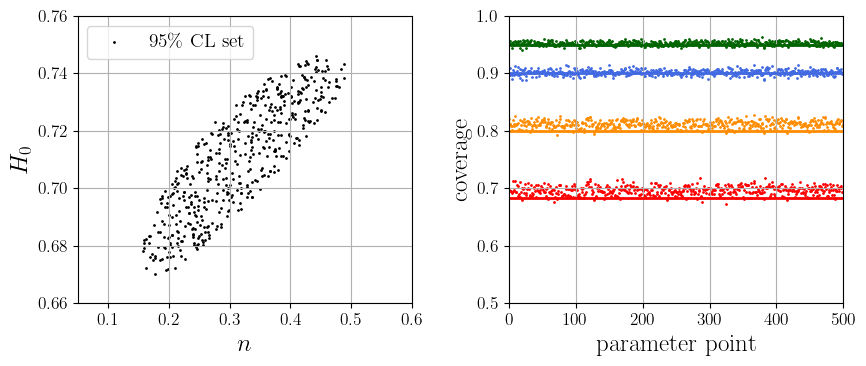

In [17]:
plot_coverage(n, H0, N, cov, bag)